### First step is to get the data
We are going to rely on the Galaxy team to pull together our sequence data for now. We might change this later.

In [1]:
import wget
from os.path import isfile

FORCE_GENOME_DOWNLOAD = False

url = 'https://covid19.galaxyproject.org/genomics/4-Variation/current_complete_ncov_genomes.fasta'
file = '../../current_complete_ncov_genomes.fasta'

if FORCE_GENOME_DOWNLOAD or not isfile(file):
    wget.download(url, file)

### Virus Alignment
Using the alignment generated by Dr. A. Will probably code to do this automatically later.


### Read the sequences into pandas so we can process them

In [2]:
import pandas as pd
from time import time
from os.path import isfile

ALIGNMENT_PATH = '../../data/position_table.csv'

print("Reading alignment table into string dictionary")
start = time()

position_table = pd.read_csv('../../data/position_table.csv')

end = time()
print(f"Read alignment table in {round(end-start, 4)} seconds")

print("Alignment table stats:")
results = position_table.describe()
print(results)

Reading alignment table into string dictionary
Read alignment table in 3.7001 seconds
Alignment table stats:
             seqid S_1_1 S_1_2 S_1_3 S_2_1 S_2_2 S_2_3 S_3_1 S_3_2 S_3_3  ...  \
count          677   677   677   677   677   677   677   677   677   677  ...   
unique         677     1     1     1     1     1     1     1     1     1  ...   
top     MT263408.1     A     T     G     T     T     T     G     T     T  ...   
freq             1   677   677   677   677   677   677   677   677   677  ...   

       S_1270_3 S_1271_1 S_1271_2 S_1271_3 S_1272_1 S_1272_2 S_1272_3  \
count       677      677      677      677      677      677      677   
unique        1        1        1        1        1        1        1   
top           A        C        A        T        T        A        C   
freq        677      677      677      677      677      677      677   

       S_1273_1 S_1273_2 S_1273_3  
count       677      677      677  
unique        1        1        1  
top        

### Pull out the concensus sequence

In [3]:
concensus_seq = position_table.drop('seqid',axis=1).mode(axis=0).T[0]
concensus_seq

S_1_1       A
S_1_2       T
S_1_3       G
S_2_1       T
S_2_2       T
           ..
S_1272_2    A
S_1272_3    C
S_1273_1    A
S_1273_2    C
S_1273_3    A
Name: 0, Length: 3819, dtype: object

### Sort samples by distance from the concensus sequence

In [4]:
from time import time

position_table = position_table.set_index('seqid')
print("Calculating distances from consensus sequence: ", end='')
start = time()
distance_from_concensus_seq = position_table.apply(lambda row: sum(row != concensus_seq),axis=1)
end = time()
print(f"{round(end-start, 4)} seconds")



print("Sorting sequences by consensus distance: ", end='')
start = time()
distance_from_concensus_seq_sorted = distance_from_concensus_seq.sort_values(ascending=False)
end = time()
print(f"{round(end-start, 4)} seconds")

Calculating distances from consensus sequence: 0.9744 seconds
Sorting sequences by consensus distance: 0.0 seconds


### Select 10 sequences to do our first analysis

In [5]:
print("10 most distant sequences from consensus")
print(distance_from_concensus_seq_sorted[0:10])
subset_seqs = distance_from_concensus_seq_sorted[:10].index

10 most distant sequences from consensus
seqid
MT233522.1    82
MT308696.1    71
MT308694.1    53
MT263453.1    48
MT259284.1    33
MT293180.1    24
MT263436.1    10
MT293224.1    10
MT326129.1    10
MT259277.1    10
dtype: int64


### Construct distance matrices for our sequences

To compare the effects of using different distance algorithms to generate the distance table, I'm going to apply as many as I can find! I'm using the textdistance package since it neatly packages many of the algorithms into objects that are easily interchangeable.

Not all of these algorithms are designed or even fit for RNA string distance, but I'm going to do more exploration on which of these works best later. Hopefully I can group together samples that occurred in the same region and classify which algorithms best predict that kind of closeness.


In [6]:
import textdistance as td
import pandas as pd
from pathlib import Path
from multiprocessing import Pool
from students.sfrazee.multiprocessing_helpers import get_distance_multi


LOCAL_DATA_DIR = "./data"
DISTANCE_CSV_SUFFIX = "_distances.csv"
INVALID_SUFFIX = "_distances.invalid"
FORCE_DISTANCE_REFRESH = False

# ensure the data folder exists
Path(LOCAL_DATA_DIR).mkdir(parents=True, exist_ok=True)

# We don't want to create objects quite yet so we can get their names
# Note: Hamming will complete relatively quickly, but other algorithms are MANY times slower
dist_algorithms = [td.Hamming, td.Levenshtein, td.DamerauLevenshtein, td.SmithWaterman, td.MLIPNS, td.JaroWinkler, td.NeedlemanWunsch, td.Gotoh]

all_distances = {}

for dist_lib in dist_algorithms:
    this_csv_path = f"{LOCAL_DATA_DIR}/{dist_lib.__name__}{DISTANCE_CSV_SUFFIX}"
    this_invalid_path = f"{LOCAL_DATA_DIR}/{dist_lib.__name__}{INVALID_SUFFIX}"

    # Only re-calculate distances if the csv doesn't exist or we want to force recalculation
    if FORCE_DISTANCE_REFRESH or \
        (not Path(this_csv_path).exists() and not Path(this_invalid_path).exists()):
        dist_alg = dist_lib()
        print(f"Calculating distances using {dist_lib.__name__} algorithm: ", end='')
        distances = {}

        #Use multiple processes to evaluate distances (THIS WILL MAX OUT YOUR CPU)
        with Pool() as pool:

            start = time()
            for i,seqid1 in enumerate(subset_seqs):
                print(f"\tCalculating all distances for {seqid1}")

                # use a list comprehension to set up the arguments for each function call
                args = [[dist_alg, position_table, seqid1, seqid2] for seqid2 in subset_seqs.values]

                # calculate this row of the distance table
                results = pool.starmap(get_distance_multi, args)
                
                for retid1, retid2, distance in results:
                    # some of the algorithms were resulting in completely negative outputs, so take the absolute value
                    distances[retid1,retid2] = abs(distance)

            end = time()
        print(f"{round(end-start, 4)} seconds")

        distances_valid = True
        print("Validating distances")

        # validate symmetric property
        for i,seqid1 in enumerate(subset_seqs):
            for j,seqid2 in enumerate(subset_seqs):
                if seqid1 != seqid2 and distances[seqid1,seqid2] != distances[seqid2,seqid1]:
                    distances_valid=False
                    print("Symmetric property violated")
                    break

        # validate triangle inequality
        if distances_valid:
            for i,seqid_i in enumerate(subset_seqs):
                if not distances_valid:
                        break
                for j,seqid_j in enumerate(subset_seqs):
                    if not distances_valid:
                        break
                    for k, seqid_k in enumerate(subset_seqs):
                        if not distances_valid:
                            break
                        if i != j and j != k and i != k:
                            if distances[seqid_i,seqid_j] > distances[seqid_i, seqid_k] + distances[seqid_j, seqid_k]:
                                distances_valid = False
                                print(f"Triangle inequality violated: {distances[seqid_i, seqid_k]}+{distances[seqid_j, seqid_k]}<{distances[seqid_i,seqid_j]}")

        # convert to pandas and save to csv
        distances = pd.Series(distances).unstack()
        if(distances_valid):
            distances.to_csv(this_csv_path)
            all_distances[dist_lib.__name__] = distances

        else:
            distances.to_csv(this_invalid_path)

    else:
        if Path(this_invalid_path).exists():
            print(f"Found {dist_lib.__name__} distances csv, but it was marked as invalid")
        else:
            print(f"Loading {dist_lib.__name__} distances from csv: ", end='')
            start = time()
            distances = pd.read_csv(this_csv_path, index_col=0)
            end = time()
            print(f"{round(end-start, 4)} seconds")
            all_distances[dist_lib.__name__] = distances


Loading Hamming distances from csv: 0.005 seconds
Loading Levenshtein distances from csv: 0.004 seconds
Loading DamerauLevenshtein distances from csv: 0.004 seconds
Loading SmithWaterman distances from csv: 0.003 seconds
Loading MLIPNS distances from csv: 0.004 seconds
Loading JaroWinkler distances from csv: 0.003 seconds
Calculating distances using NeedlemanWunsch algorithm: 	Calculating all distances for MT233522.1
	Calculating all distances for MT308696.1
	Calculating all distances for MT308694.1
	Calculating all distances for MT263453.1
	Calculating all distances for MT259284.1
	Calculating all distances for MT293180.1
	Calculating all distances for MT263436.1
	Calculating all distances for MT293224.1
	Calculating all distances for MT326129.1
	Calculating all distances for MT259277.1
2218.8936 seconds
Validating distances
Triangle inequality violated: -3684.0+-3797.0<-3668.0
Calculating distances using Gotoh algorithm: 	Calculating all distances for MT233522.1
	Calculating all dist

### Utilize biopython
Convert from panda dataframes to distance matrices.

In [7]:
from Bio.Phylo.TreeConstruction import DistanceMatrix

all_matrices = {}

for d_key, distances in all_distances.items():

    matrix = pd.np.tril(distances.values).tolist()
    for i in range(len(matrix)):
        matrix[i] = matrix[i][:i+1]
    dm = DistanceMatrix(list(distances.index), matrix)

    all_matrices[d_key] = dm

c:\users\sfrazee\.virtualenvs\csc-448-project-nhuursrk\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


### Now construct and draw our trees
(More annotation coming later)

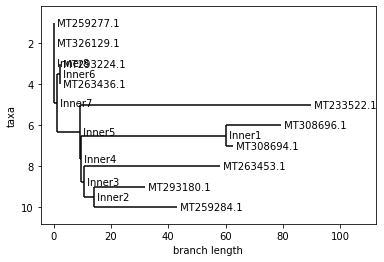

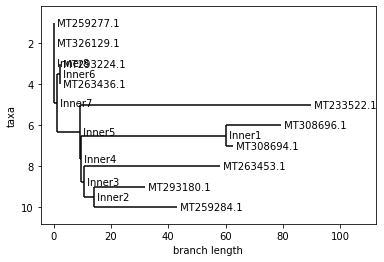

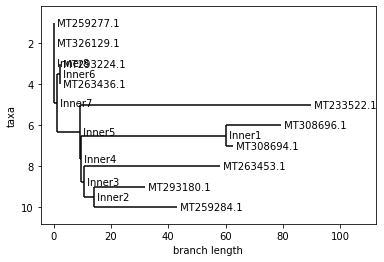

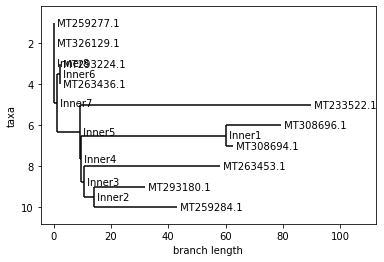

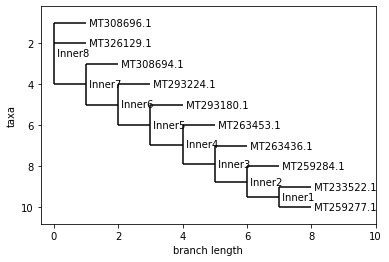

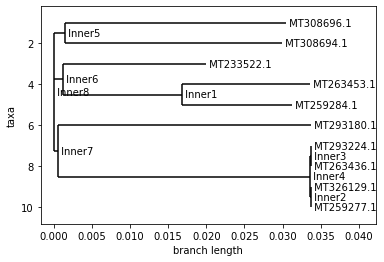

In [8]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

for dm in all_matrices.values():

    constructor = DistanceTreeConstructor()
    tree = constructor.nj(dm)

    %matplotlib inline

    tree.ladderize()   # Flip branches so deeper clades are displayed at top
    Phylo.draw(tree)

